In [14]:
# Cálculo de infiltración.

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import geopandas as gpd

from scipy import integrate
from scipy import optimize

In [15]:
# Dirección de los datos.
path = "../Material/Clases/Clase 16/"

# Escurrimiento.
esc_n  = "Escurrimiento.csv"
# Curva masa.
cm_n   = "curva_masa_media.csv"
# Contorno de las subcuencas.
subc_n = "Zona_36080.shp"

# Cargamos los datos.
esc = pd.read_csv(path + esc_n, index_col = "tiempo")
esc.index = pd.to_datetime(esc.index)
cm  = pd.read_csv(path + cm_n, index_col = "fecha")
cm.index = pd.to_datetime(cm.index)
cm.index.name = esc.index.name
subc  = gpd.read_file(path + subc_n)

In [16]:
# Escurrimiento.

# Gasto pico.
t_q_max = esc["ngasto"].idxmax()

# Integramos el tiempo en segundos y los gastos
# para obtener los volúmenes de escurrimiento.
V_B = integrate.simpson(esc["Q_B"], esc["seconds"])
V_D = integrate.simpson(esc["Q_D"], esc["seconds"])

# Calculamos la precipitación en exceso.
h_e = V_D * 1000 / subc.area[0]

# Tiempo pico y tiempo base en horas.
t_p = esc.loc[t_q_max, "seconds"] / 3600 
t_b = esc["seconds"].max() / 3600 

print(f"Volumen de escurrimiento base   : {V_B:7.0f} m^3")
print(f"Volumen de escurrimiento directo: {V_D:7.0f} m^3")
print()
print(f"precipitación en exceso         : {h_e:7.2f} mm")
print()

Volumen de escurrimiento base   : 61687339 m^3
Volumen de escurrimiento directo: 131298711 m^3

precipitación en exceso         :   12.88 mm



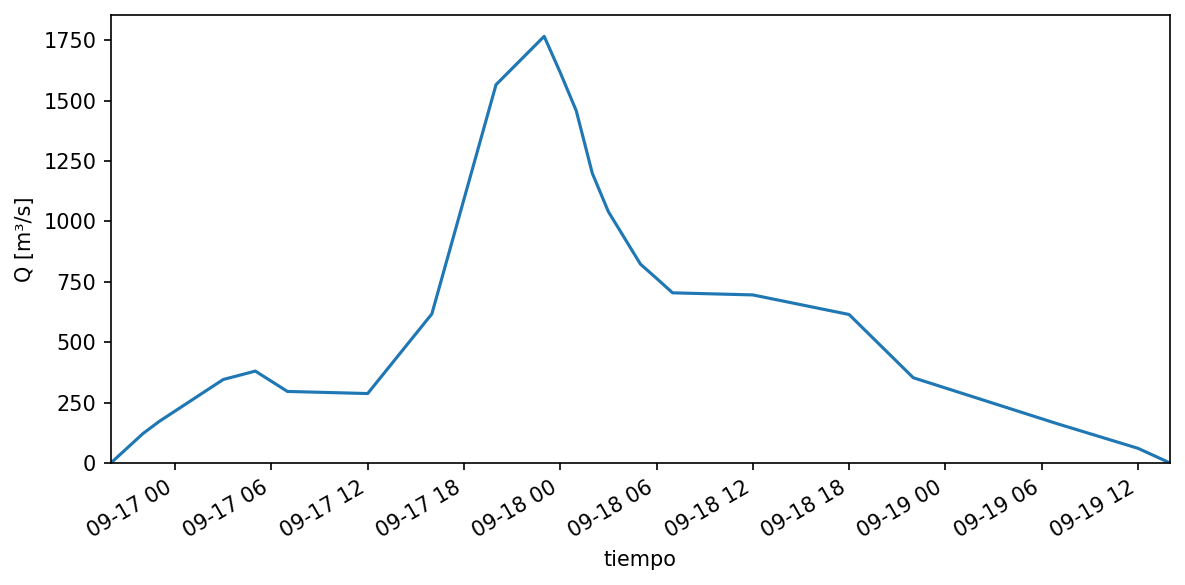

In [17]:
# Gasto directo.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 4)
fig.set_dpi(150) 

# Gasto directo.
esc["Q_D"].plot(ax = ax)

# Estilo.
ax.set_ylim(0)
ax.set_xlim( esc.index.min(), esc.index.max() )
ax.set_ylabel("Q [m³/s]")

fig.tight_layout()
plt.show()

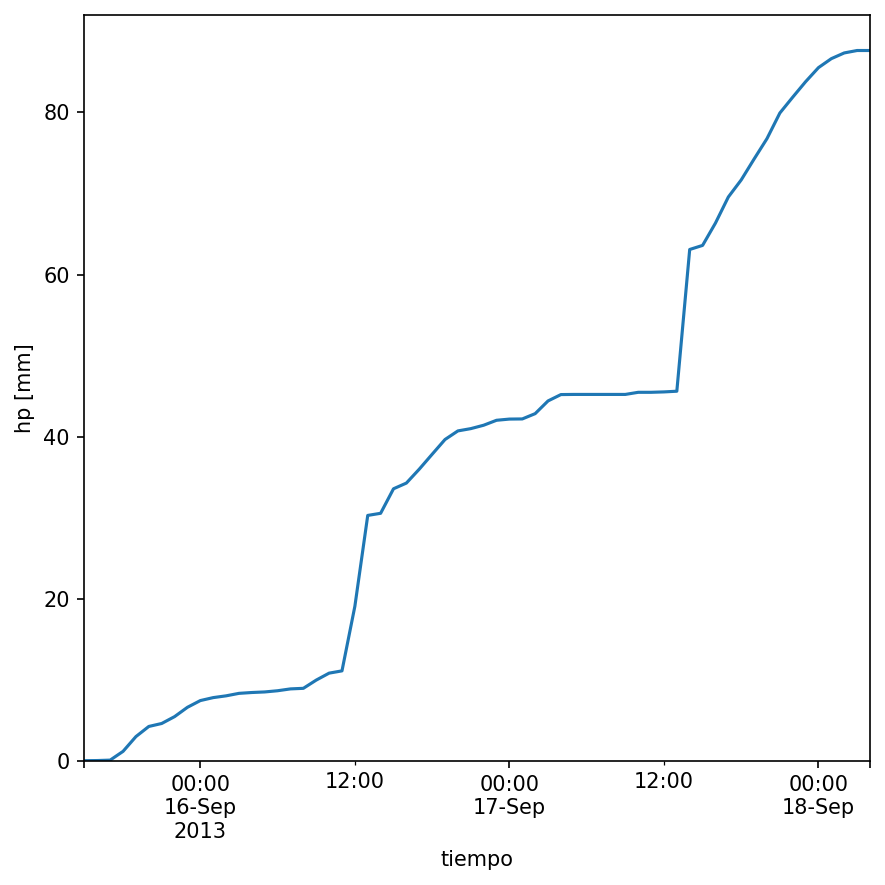

In [18]:
# Curva masa.

# Precipitación total.
h_p = cm["hp [mm]"].sum()

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos la curva masa.
cm["curva masa [mm]"].plot(ax = ax)

# Estilo.
ax.set_ylim(0)
ax.set_ylabel("hp [mm]")

fig.tight_layout()
plt.show()

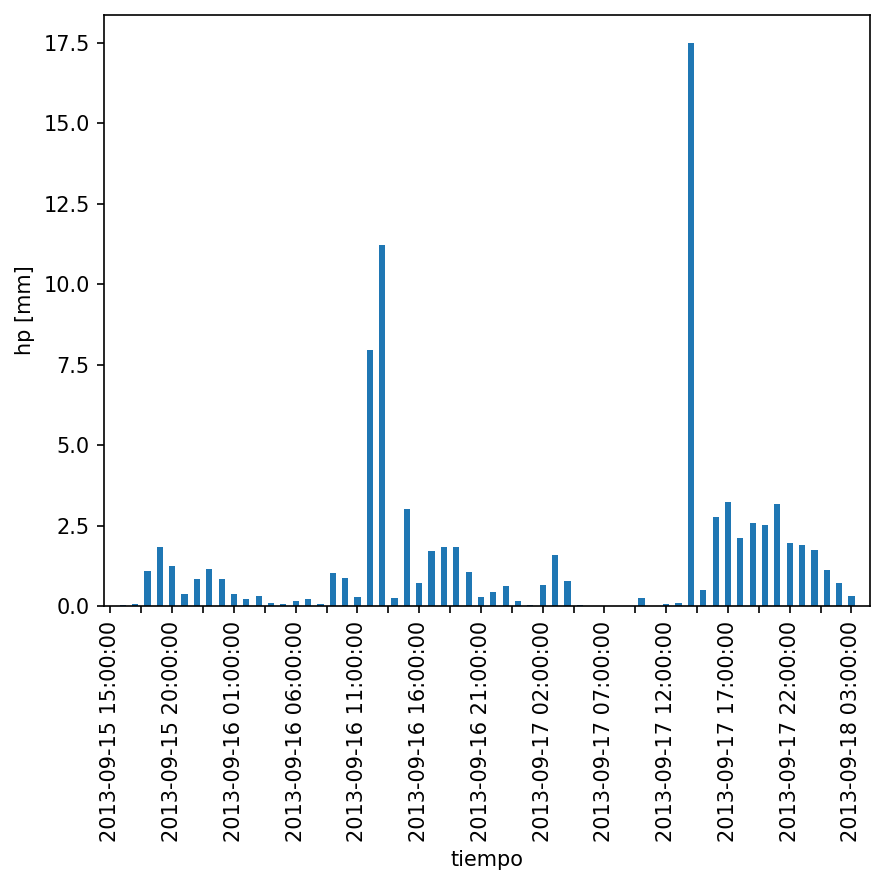

In [19]:
# Hietograma.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos el hietograma.
cm["hp [mm]"].plot.bar(ax = ax)

# Estilo.
ax.set_ylim(0)
ax.set_ylabel("hp [mm]")
ax.xaxis.set_major_locator( plt.MaxNLocator(30) )

fig.tight_layout()
plt.show()

In [20]:
# Método aforado.

print( f"Precipitación total: {h_p:.3f} [mm]" )
print( f"Precipitación en exceso: {h_e:.3f} [mm]" )

# Infiltración total.
F = h_p - h_e
print( f"Infiltración total: {F:.3f} [mm]" )


Precipitación total: 87.651 [mm]
Precipitación en exceso: 12.884 [mm]
Infiltración total: 74.767 [mm]


In [21]:
# Coeficiente de infiltración media.

# Función para calcular phi por medio de solución numérica.
def calc_phi(phi):
    return ( cm["hp [mm]"] - phi).sum() - h_e

# Función para calcular la lluvia en exceso.
def calc_h_e(x):
    # El valor mínimo de precipitación es 0.
    if x - phi < 0: return 0
    else: return x - phi

# Encontramos numéricamente el valor de phi.
phi = optimize.fsolve(calc_phi, x0 = 0)[0]
print(f"Coeficiente de infiltración media: {phi:.3f} [mm]")

# Calculamos la precipitación en exceso.
cm["he [mm]"] = cm["hp [mm]"].apply(calc_h_e)

# Calculamos el delta de tiempo en horas.
dt = (cm.index[1] - cm.index[0]).seconds / 60 / 60
# La duración en exceso es el tiempo en que
# la precipitación en exceso es mayor a 0.
d_e = ( cm["he [mm]"] > 0 ).sum()
print(f"Duración en exceso: {d_e} [horas]")

Coeficiente de infiltración media: 1.226 [mm]
Duración en exceso: 19 [horas]


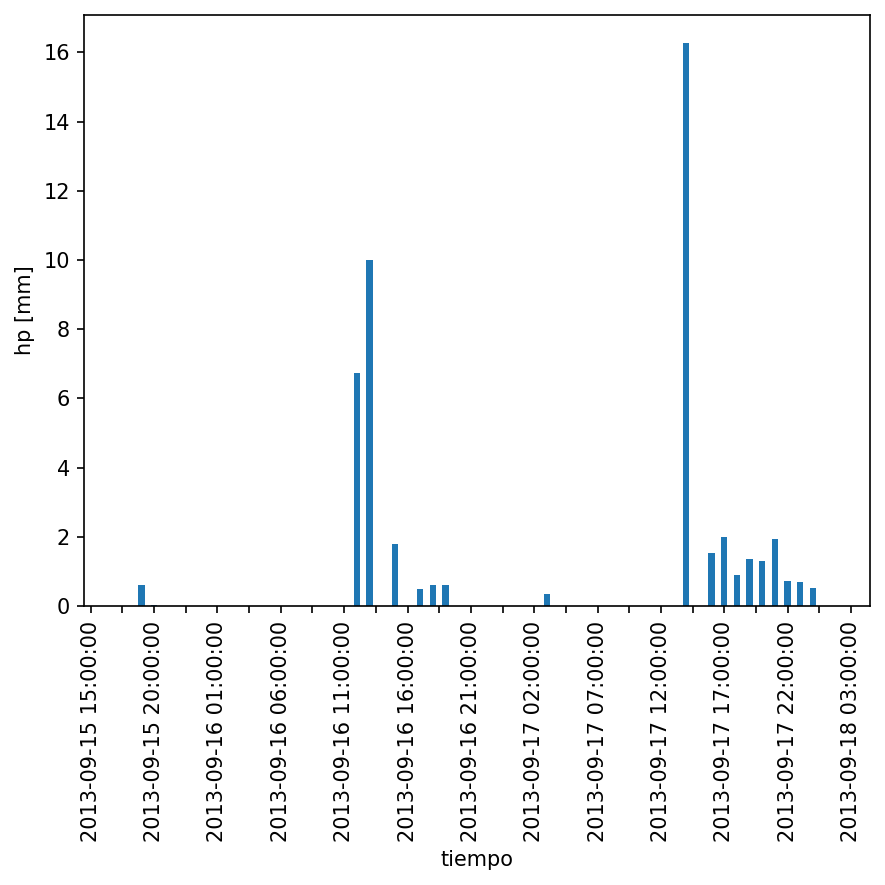

In [22]:
# Peecipitación en exceso.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos el hietograma en exceso.
cm["he [mm]"].plot.bar(ax = ax)

# Estilo.
ax.set_ylim(0)
ax.set_ylabel("hp [mm]")
ax.xaxis.set_major_locator( plt.MaxNLocator(30) )

fig.tight_layout()
plt.show()

In [23]:
# Coeficiente de escurrimiento.
C_e = h_e / h_p
print( f"Coeficiente de escurrimiento: {C_e:.3f}" )

# Lámina de escurrimiento.
cm["r [mm/h]"] = cm["i [mm/h]"] * C_e
# Lámina de infiltración.
cm["f [mm/h]"] = 1 - cm["r [mm/h]"]

cm.to_csv(path + "infiltracion.csv")

Coeficiente de escurrimiento: 0.147


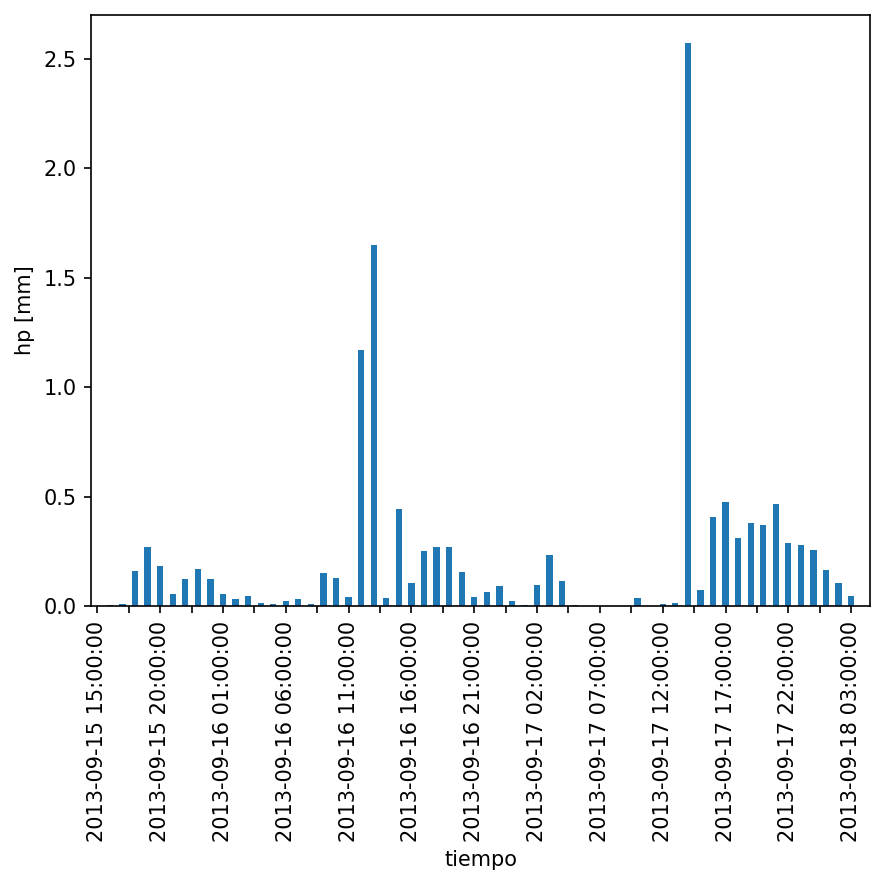

In [24]:
# Lámina de escurrimiento

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos el hietograma de la lámina de escurrimiento.
cm["r [mm/h]"].plot.bar(ax = ax)

# Estilo.
ax.set_ylim(0)
ax.set_ylabel("hp [mm]")
ax.xaxis.set_major_locator( plt.MaxNLocator(30) )

fig.tight_layout()
plt.show()

In [25]:
# Criterio del USCS.
# Como conocemos C_e y h_p, podemos encontrar el coeficiente S.
# En la realidad tendríamos que repetir esto para varias
# tormentas y encontrar S tal que se minimice el error.

# Variables del criterio del UCSC.
P   = h_p

# Función para calcular el coeficiente de escurrimiento.
def calc_C_e(C_e, S):
    return ( P - 0.2 * S ) ** 2 / ( P ** 2 + 0.8 * S * P )
# Función para calcular S por medio de solución numérica.
def opt_S(S):
    return C_e - calc_C_e(C_e, S)

# Encontramos S por métodos numéricos.
S = optimize.fsolve(opt_S, x0 = 0)[0]
print(f"Coeficiente del método del UCSC: {S:.1f} [mm]")

Coeficiente del método del UCSC: 169.9 [mm]


In [26]:
# Número de curva.
# Como conocemos h_e y h_p, podemos encontrar
# el número de curva medio de la cuenca.

# Variables del método de número de curva.
P   = h_p / 10
P_e = h_e / 10

# Función para calcular la precipitación en exceso.
def calc_P_e(P, N):
    return (P - 508 / N + 5.08) ** 2 / (P + 2032 / N + 20.32)
# Función para calcular N por medio de solución numérica.
def opt_N(N):
    return P_e - calc_P_e(P, N)

# Encontramos N por métodos numéricos.
N = optimize.fsolve(opt_N, x0 = 10)[0]
print(f"Número de curva medio: {N:.1f}")

Número de curva medio: 18.7
